### Transcriptomics analysis

Within hotspot vs. all other samples: 9.930031747144944e-05
All mutation vs. wildtype: 6.652133477614123e-07


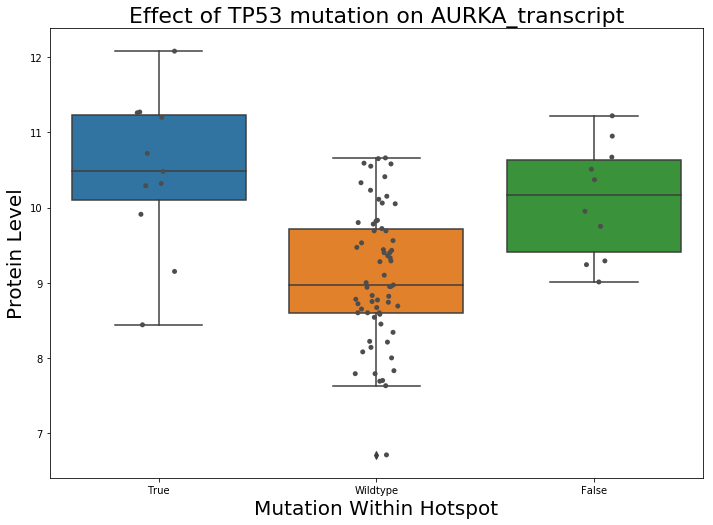

In [37]:
gene = 'TP53'
protein = 'AURKA'

# 1. Get the mutation data as before with the CPTAC package, create the within_hotspot column
p53_transcript_mut = CPTAC.compare_mutations(proteomics, gene)
p53_transcript_mut['Within_Hotspot'] = False
p53_transcript_mut.loc[hotspot_patients, 'Within_Hotspot'] = True
p53_transcript_mut.loc[p53_transcript_mut['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_transcript_mut = p53_transcript_mut.loc[p53_transcript_mut['Patient_Type'] == 'Tumor'].dropna(axis=0)

# 2. Add the transcriptomics data
prot_transcript = pd.DataFrame(transcriptomics[protein])
prot_transcript.columns = [protein + '_transcript']
protein = protein + '_transcript'

transcript_analysis = p53_transcript_mut.join(prot_transcript).drop(gene, axis=1).dropna(axis=0)
transcript_analysis = transcript_analysis.loc[transcript_analysis['Patient_Type'] == 'Tumor']

# 3. Perform t-tests
in_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] == True]
outside_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] != True]
htspt_ttest = scipy.stats.ttest_ind(in_hotspot[protein], outside_hotspot[protein])
print("Within hotspot vs. all other samples: " + str(htspt_ttest[1]))
mutated_all = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] != 'Wildtype']
wt_all = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] == 'Wildtype']
all_ttest = scipy.stats.ttest_ind(mutated_all[protein], wt_all[protein])
print("All mutation vs. wildtype: " + str(all_ttest[1]))

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = transcript_analysis, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = transcript_analysis, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein, fontsize='22')
plt.show()